# 📊 Análisis de Reservas - esBarre

Este notebook se centra **solo en las reservas (visitas)**, partiendo del mismo fichero de Mindbody.

En este análisis vamos a:
- Cargar y preparar los datos de reservas.
- Excluir agosto (mes cerrado) para que no distorsione la serie.
- Ver la evolución de las reservas por mes y por local.
- Calcular reservas por persona (media) y su evolución.

Más adelante podremos añadir: reservas por tipo de reserva, por canal, nuevos vs recurrentes, etc.


In [4]:
# 1. Importar librerías y configurar entorno

import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✅ Librerías cargadas")

# 2. Cargar datos de Mindbody (visitas / reservas)

RUTA_FICHERO = 'Detailed Visit Information.json'

with open(RUTA_FICHERO, 'r') as f:
    data = json.load(f)

reservas = pd.DataFrame(data)

# 3. Preparar fechas y columnas auxiliares

# Convertir columnas de fecha
reservas['Fecha de Visita'] = pd.to_datetime(reservas['Fecha de Visita'], format='mixed')
reservas['Fecha y Hora de Creacion UTC'] = pd.to_datetime(reservas['Fecha y Hora de Creacion UTC'], format='mixed')

# Columnas de año/mes
reservas['Año'] = reservas['Fecha de Visita'].dt.year
reservas['Mes'] = reservas['Fecha de Visita'].dt.month
reservas['Año-Mes'] = reservas['Fecha de Visita'].dt.to_period('M')
reservas['Mes_Nombre'] = reservas['Fecha de Visita'].dt.strftime('%Y-%m')

# Excluir diciembre 2025 si quieres ser consistente con el otro notebook
reservas = reservas[~((reservas['Año'] == 2025) & (reservas['Mes'] == 12))]

# Excluir agosto (estudio cerrado)
reservas = reservas[reservas['Mes'] != 8]

print("✅ Fechas preparadas, agosto y dic-2025 excluidos")
print(f"📅 Rango de fechas: {reservas['Fecha de Visita'].min().date()} a {reservas['Fecha de Visita'].max().date()}")


reservas.head(3)


✅ Librerías cargadas
✅ Fechas preparadas, agosto y dic-2025 excluidos
📅 Rango de fechas: 2024-09-11 a 2025-11-30


,Categoria de Visita,Email,Esta Cancelada,Esta Perdida,Fecha de Visita,Fecha y Hora de Creacion UTC,ID de Ubicacion,ID de la Clase,ID del Cliente,ID del Estudio,ID del Grupo de Tipos,ID del Tipo de Visita,Indicador de Servicios Adicionales,Is Complimentary,Is Staff Paid,Most Recent Visit Date,Nombre de la Clase,Nombre de la Ubicacion,Nombre del Cliente,Nombre del Sitio,Numero de Referencia de la Visita,Payment Method Ids,Payment Method Names,Pmtrefno,Pricing Option,Primera Reserva,Registrado,Reserva Online,Tipo de Visita,Trainer Full Name,Trainer Id,Visit Service Category Name,Visitas Totales,Visits Remaining on Pricing Option,Reserva de Hitos,Visit Room,Año,Mes,Año-Mes,Mes_Nombre
195,CLASS,vidal.yara@gmail.com,0,0,2025-11-30,2025-11-26 22:36:18.600,2,654,100012099,5738675,23,47,Non-Add On,0,1,2025-11-30 00:00:00,esPause,Trafalgar - esBarré,Yarq Vidal,esBarre,79398,801,Apple Pay,52339,1 Clase,1,1.0,True,Barre,Adriana Ramos,100000031,Bonos,42280,0,NaN,NaN,2025,11,2025-11,2025-11
196,CLASS,alessandra.miglio@gmail.com,0,0,2025-11-30,2025-11-24 22:38:05.000,2,655,100010887,5738675,23,47,Non-Add On,0,1,2025-11-30 00:00:00,esPause,Trafalgar - esBarré,Alessandra Miglio,esBarre,78827,9,Otro,47760,DESCUENTO 50% BONO 5 TRAFALGAR,0,1.0,True,Barre,Adriana Ramos,100000031,Bonos,42280,1,NaN,NaN,2025,11,2025-11,2025-11
197,CLASS,iria.villamarin@gmail.com,0,0,2025-11-30,2025-11-24 16:34:53.000,2,655,100004208,5738675,23,47,Non-Add On,1,1,2025-11-30 00:00:00,esPause,Trafalgar - esBarré,Iria Eiriz,esBarre,78680,7,Cortesía/Invitado,15783,Gympass,0,1.0,False,Barre,Adriana Ramos,100000031,Bonos,42280,0,NaN,NaN,2025,11,2025-11,2025-11


In [5]:
# 4. Resumen general rápido de reservas

print("="*60)
print("📊 RESUMEN GENERAL DE RESERVAS")
print("="*60)

print(f"Total de reservas (visitas): {len(reservas):,}")
print(f"Clientes únicos: {reservas['ID del Cliente'].nunique():,}")
print(f"Clases distintas: {reservas['ID de la Clase'].nunique():,}")
print(f"Locales: {reservas['Nombre de la Ubicacion'].nunique():,}\n")

print("🏢 Reservas por local:")
res_por_local = reservas['Nombre de la Ubicacion'].value_counts()
for loc, n in res_por_local.items():
    clientes_loc = reservas[reservas['Nombre de la Ubicacion'] == loc]['ID del Cliente'].nunique()
    print(f"  - {loc}: {n:,} reservas | {clientes_loc:,} clientes")

print("\n📅 Reservas por mes (total):")
res_por_mes = reservas.groupby('Mes_Nombre').size()
display(res_por_mes.to_frame('Reservas'))


📊 RESUMEN GENERAL DE RESERVAS
Total de reservas (visitas): 41,445
Clientes únicos: 8,832
Clases distintas: 562
Locales: 2

🏢 Reservas por local:
  - López de Hoyos - esBarre: 38,484 reservas | 7,825 clientes
  - Trafalgar - esBarré: 2,961 reservas | 1,381 clientes

📅 Reservas por mes (total):


,Reservas
Mes_Nombre,
2024-09,1362
2024-10,3229
2024-11,3098
2024-12,2248
2025-01,2960
2025-02,3156
2025-03,3529
2025-04,2741
2025-05,2921


📊 Tabla de reservas por mes y local con métricas:


Nombre de la Ubicacion,López de Hoyos - esBarre,Trafalgar - esBarré,TOTAL,MoM% López,MoM% Trafalgar,López vs Trafalgar %,YoY% López
Año-Mes,,,,,,,
2024-09,1362,0,1362,-,-,-,-
2024-10,3229,0,3229,+137.1%,-,-,-
2024-11,3098,0,3098,-4.1%,-,-,-
2024-12,2248,0,2248,-27.4%,-,-,-
2025-01,2960,0,2960,+31.7%,-,-,-
2025-02,3156,0,3156,+6.6%,-,-,-
2025-03,3529,0,3529,+11.8%,-,-,-
2025-04,2741,0,2741,-22.3%,-,-,-
2025-05,2921,0,2921,+6.6%,-,-,-


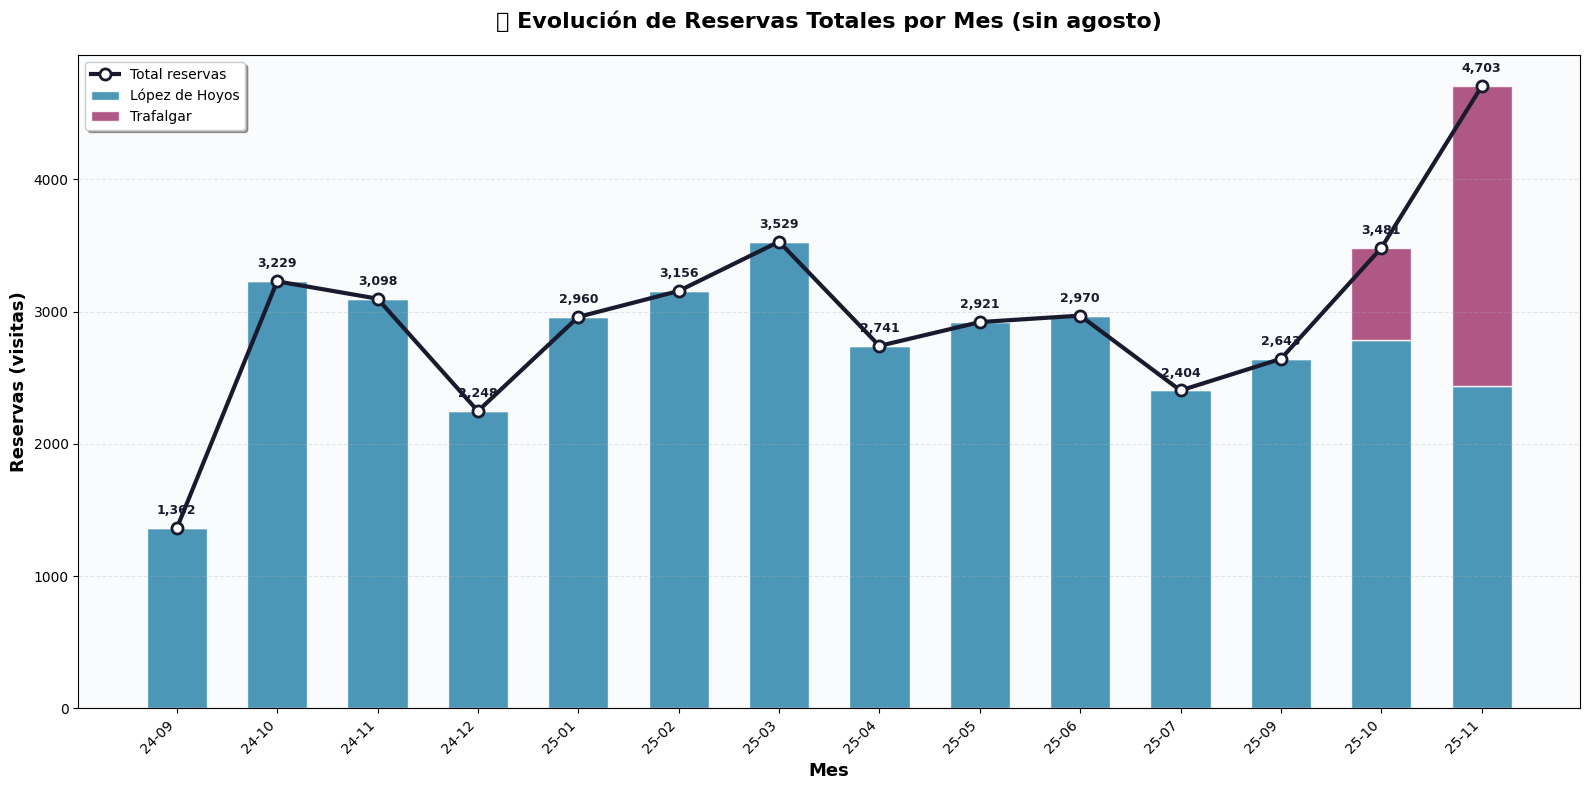

In [9]:
# 5. Evolución de reservas totales por mes y por local

# Agrupar reservas por mes y local
res_mes_loc = (
    reservas
    .groupby(['Año-Mes', 'Nombre de la Ubicacion'])
    .size()
    .reset_index(name='Reservas')
)

pivot_res_mes_loc = res_mes_loc.pivot(index='Año-Mes', columns='Nombre de la Ubicacion', values='Reservas').fillna(0)

# Orden cronológico
pivot_res_mes_loc = pivot_res_mes_loc.sort_index()

# Calcular total
pivot_res_mes_loc['TOTAL'] = pivot_res_mes_loc.sum(axis=1)

# Crear DataFrame con métricas adicionales
tabla_completa = pivot_res_mes_loc.astype(int).copy()

# Calcular MoM% para López de Hoyos
lopez_col = 'López de Hoyos - esBarre'
trafalgar_col = 'Trafalgar - esBarré'

tabla_completa['MoM% López'] = tabla_completa[lopez_col].pct_change() * 100
tabla_completa['MoM% Trafalgar'] = tabla_completa[trafalgar_col].pct_change() * 100

# Comparación entre locales (López vs Trafalgar en %)
tabla_completa['López vs Trafalgar %'] = tabla_completa.apply(
    lambda row: ((row[lopez_col] - row[trafalgar_col]) / row[trafalgar_col] * 100) if row[trafalgar_col] > 0 else None, axis=1
)

# Calcular YoY% para López de Hoyos (Sep, Oct, Nov 2025 vs 2024)
tabla_completa['YoY% López'] = None

# Crear diccionario de valores 2024 para López de Hoyos
lopez_2024 = {}
for periodo in tabla_completa.index:
    periodo_str = str(periodo)
    if periodo_str.startswith('2024'):
        mes = periodo_str[-2:]
        lopez_2024[mes] = tabla_completa.loc[periodo, lopez_col]

# Calcular YoY para meses de 2025
for periodo in tabla_completa.index:
    periodo_str = str(periodo)
    if periodo_str.startswith('2025'):
        mes = periodo_str[-2:]
        if mes in ['09', '10', '11'] and mes in lopez_2024:
            valor_2025 = tabla_completa.loc[periodo, lopez_col]
            valor_2024 = lopez_2024[mes]
            if valor_2024 > 0:
                yoy = ((valor_2025 - valor_2024) / valor_2024) * 100
                tabla_completa.loc[periodo, 'YoY% López'] = yoy

# Formatear columnas de porcentaje
def format_pct(val):
    if pd.isna(val) or val is None:
        return '-'
    return f"{val:+.1f}%"

tabla_display = tabla_completa.copy()
tabla_display['MoM% López'] = tabla_display['MoM% López'].apply(format_pct)
tabla_display['MoM% Trafalgar'] = tabla_display['MoM% Trafalgar'].apply(format_pct)
tabla_display['López vs Trafalgar %'] = tabla_display['López vs Trafalgar %'].apply(format_pct)
tabla_display['YoY% López'] = tabla_display['YoY% López'].apply(format_pct)

print("📊 Tabla de reservas por mes y local con métricas:")
display(tabla_display)

# Gráfico similar al de clientes activos
fig, ax = plt.subplots(figsize=(16, 8))

meses = [str(p) for p in pivot_res_mes_loc.index]
x = np.arange(len(meses))

color_lopez = '#2E86AB'
color_trafalgar = '#A23B72'
color_total = '#1a1a2e'

lopez_data = pivot_res_mes_loc.get('López de Hoyos - esBarre', pd.Series(0, index=pivot_res_mes_loc.index)).values
trafalgar_data = pivot_res_mes_loc.get('Trafalgar - esBarré', pd.Series(0, index=pivot_res_mes_loc.index)).values
total_data = pivot_res_mes_loc['TOTAL'].values

width = 0.6
ax.bar(x, lopez_data, width, label='López de Hoyos', color=color_lopez, alpha=0.85, edgecolor='white')
ax.bar(x, trafalgar_data, width, bottom=lopez_data, label='Trafalgar', color=color_trafalgar, alpha=0.85, edgecolor='white')

ax.plot(x, total_data, color=color_total, linewidth=3, marker='o', markersize=8,
        label='Total reservas', zorder=5, markerfacecolor='white', markeredgewidth=2)

for i, total in enumerate(total_data):
    ax.annotate(f'{int(total):,}', (x[i], total), textcoords='offset points',
                xytext=(0, 10), ha='center', fontsize=9, fontweight='bold', color=color_total)

ax.set_xlabel('Mes', fontsize=13, fontweight='bold')
ax.set_ylabel('Reservas (visitas)', fontsize=13, fontweight='bold')
ax.set_title('📊 Evolución de Reservas Totales por Mes (sin agosto)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m[2:] for m in meses], rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()
